In [1]:
import pandas as pd
import numpy as np
import os.path
import time

#script calcs
from fma_calc import *

#graphs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

#models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

#avaliate models
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import preprocessing

In [2]:
path_base = './database/'

#carregar dados
data_train = pd.read_csv(path_base + 'data.csv', index_col=0, header=[0, 1, 2])

In [3]:
data_train.shape

(11293, 371)

In [4]:
data_train

client_id  \
                                                                           null   
                                                                           null   
common_voice_pt_20465003.mp3  228433504b72862dcbb94dbbb5adfb1e7828e5333607a6...   
common_voice_pt_20465004.mp3  228433504b72862dcbb94dbbb5adfb1e7828e5333607a6...   
common_voice_pt_20465005.mp3  228433504b72862dcbb94dbbb5adfb1e7828e5333607a6...   
common_voice_pt_20465007.mp3  228433504b72862dcbb94dbbb5adfb1e7828e5333607a6...   
common_voice_pt_20465010.mp3  228433504b72862dcbb94dbbb5adfb1e7828e5333607a6...   
...                                                                         ...   
common_voice_pt_20157108.mp3  9d91497cb25399ad6cf6a4d88548fa84ee3c3687363015...   
common_voice_pt_20329211.mp3  9d91497cb25399ad6cf6a4d88548fa84ee3c3687363015...   
common_voice_pt_20374419.mp3  9d91497cb25399ad6cf6a4d88548fa84ee3c3687363015...   
common_voice_pt_20374443.mp3  9d91497cb25399ad6cf6a4d88548fa84ee3c3687363015...   
common_voice_pt_20490306.mp3  9d91497cb25399ad6cf6a4d88548fa84ee3c3687363015...   

                                   zcr                                \
                                  mean       std    median       min   
                                     1         1         1         1   
common_voice_pt_20465003.mp3  0.125353  0.103745  0.115723  0.000000   
common_voice_pt_20465004.mp3  0.098185  0.092857  0.069824  0.000000   
common_voice_pt_20465005.mp3  0.080865  0.060174  0.066162  0.008789   
common_voice_pt_20465007.mp3  0.121636  0.103982  0.116699  0.000000   
common_voice_pt_20465010.mp3  0.087548  0.069991  0.051758  0.000000   
...                                ...       ...       ...       ...   
common_voice_pt_20157108.mp3  0.059966  0.073004  0.026367  0.000000   
common_voice_pt_20329211.mp3  0.032669  0.042891  0.018555  0.000000   
common_voice_pt_20374419.mp3  0.026786  0.045298  0.013184  0.000000   
common_voice_pt_20374443.mp3  0.022909  0.032702  0.014160  0.000000   
common_voice_pt_20490306.mp3  0.032358  0.056402  0.000000  0.000000   

                                       chroma_cqt                      \
                                   max       mean                       
                                     1          1         2         3   
common_voice_pt_20465003.mp3  0.416504   0.557357  0.622126  0.649300   
common_voice_pt_20465004.mp3  0.437500   0.554937  0.451040  0.455339   
common_voice_pt_20465005.mp3  0.249023   0.650339  0.466485  0.433027   
common_voice_pt_20465007.mp3  0.464355   0.449849  0.426313  0.475708   
common_voice_pt_20465010.mp3  0.423340   0.473176  0.572995  0.445299   
...                                ...        ...       ...       ...   
common_voice_pt_20157108.mp3  0.238770   0.417725  0.473786  0.484777   
common_voice_pt_20329211.mp3  0.205078   0.671689  0.559520  0.456264   
common_voice_pt_20374419.mp3  0.271973   0.538729  0.534908  0.326160   
common_voice_pt_20374443.mp3  0.228027   0.536465  0.557007  0.351216   
common_voice_pt_20490306.mp3  0.244629   0.377814  0.277383  0.303506   

                                        ...       mfcc                        \
                                        ...        max                         
                                     4  ...         11         12         13   
common_voice_pt_20465003.mp3  0.509346  ...  32.817814  17.369915  25.318813   
common_voice_pt_20465004.mp3  0.457674  ...  26.015247  15.764002  32.101944   
common_voice_pt_20465005.mp3  0.452168  ...  33.945107  14.430111  31.920970   
common_voice_pt_20465007.mp3  0.451849  ...  39.097427  21.634668  41.013718   
common_voice_pt_20465010.mp3  0.496044  ...  23.994175  22.745077  18.994186   
...                                ...  ...        ...        ...        ...   
common_voice_pt_20157108.mp3  0.311865  ...  34.389973  25.462936  51.544899   
common_voice_pt_20329211.mp3  0.457558  ...  15.741443  28.867592  29.77296

In [5]:
#verificar quantidade de clientes e número mínimo e máximo de examples
data_client_count = data_train.groupby(("client_id", "null", "null")).count()
print("Clients: %d, min example %d, max example %d" 
      % (data_client_count.shape[0], data_client_count[("zcr", "mean", "1")].min(), data_client_count[("zcr", "mean", "1")].max()))

Clients: 90, min example 26, max example 1176


In [6]:
def data_split(data, test_size = 0.33, random_state = 0, min_examples = None, limit_example = None):
    '''
    Separa dados em treinamento e teste, deixando examples relativamente iguais a base.
    parametros:
    min_examples = mínimo exemplos que uma pessoa deve ter. Caso tenha menos nos dados a pessoa não é usada
    limit_example = limita examplos para uma pessoa. Caso a pessoa tenha mais examples que o limite, parte deles é descartada
    
    retorna tuple (X treino, X teste, y treino, y teste)
    '''
    
    #deixa dados aleatorios
    data_f = data.sample(frac=1, random_state=random_state)
    
    #create database train
    data_example = pd.DataFrame(columns=data_f.columns)
    data_example.index.name = "track_id"

    #create database test
    test_example = pd.DataFrame(columns=data_f.columns)
    test_example.index.name = "track_id"
    
    for i in range(0, len(data_f)):
        row = data_f.iloc[i]
        
        #número de exemplos do cliente na base
        n_client_example = data_f[data_f[("client_id", "null", "null")] == row[("client_id", "null", "null")]][("zcr", "mean", "1")].count()
        
        #caso tenha menos examplos que o parametro min_examples, não utiliza a pessoa
        if not min_examples is None and n_client_example < min_examples:
            continue
            
        #caso número de examplos seja maior que o parametro limite_examples, diz que o número de exemplos da base é igual ao limite exemplos
        if not limit_example is None and n_client_example > limit_example:
            n_client_example = limit_example
        
        #calcula o número de exemplos para o teste
        n_test = n_client_example * test_size
        if n_test%2 > 0:
            n_test = int(n_test)
            if n_test + 1 == n_client_example:
                n_test = int(n_test) - 1
            else:
                n_test = n_test + 1
        else:
            n_test = int(n_test)
        
        #can not use this client low examples
        if n_test == 0 or n_test == n_client_example:
            continue
           
        #adiciona os exemplos na nova base de teste e quando teste tem o número de exemplos limite, coloca na base de treino
        if test_example[test_example[("client_id", "null", "null")] == row[("client_id", "null", "null")]][("zcr", "mean", "1")].count() < n_test:
            test_example = test_example.append(row)
        elif limit_example is None or data_example[data_example[("client_id", "null", "null")] == row[("client_id", "null", "null")]][("zcr", "mean", "1")].count() < limit_example:
            data_example = data_example.append(row)
    
    #seta X treino e y treino
    X_train = data_example.drop([("client_id", "null", "null")], axis=1)
    y_train = data_example[("client_id", "null", "null")]

    #seta X teste e y teste
    X_test = test_example.drop([("client_id", "null", "null")], axis=1)
    y_test = test_example[("client_id", "null", "null")]

    return (X_train, X_test, y_train, y_test)

In [7]:
#seta dados de treino e teste. Obs foi necessário limitar o número de registro através dos parametros min_examples e limit_examples, para utilizar o GridSearchCV
X_train, X_test, y_train, y_test = data_split(data_train, test_size=0.33, random_state=42, min_examples = 100, limit_example = 130)

In [8]:
X_train.shape

(3422, 370)

In [9]:
#verificar quantidade de clientes e número mínimo e máximo de examples
data_client_count = pd.concat([X_train,y_train],axis=1).groupby(("client_id", "null", "null")).count()
print("Clients: %d, min example %d, max example %d" 
      % (data_client_count.shape[0], data_client_count[("zcr", "mean", "1")].min(), data_client_count[("zcr", "mean", "1")].max()))

Clients: 33, min example 69, max example 130


In [10]:
#busca de colunas correlacionadas, método drop_correlation retorna array com uma das colunas correlacionadas
fname_corr = path_base + 'corr.csv'
if not os.path.isfile(fname_corr):
    corr_cols = drop_correlation(X_train)
    
    #save correlation drop cols
    pd.Series(corr_cols).to_csv(fname_corr, index=False)
else:
    corr_cols = [eval(i) for i in list(pd.read_csv(fname_corr)["0"])]

In [11]:
#drop correlate features of train
X_train = X_train.drop(corr_cols, axis=1)

In [12]:
print("Compare first features %s now %s" % (data_train.shape[1], X_train.shape[1]))

Compare first features 371 now 284


In [13]:
f_col_describe = X_train.describe().T

#busca por colunas irrelevantes. Aqui foi verificado colunas que tinha 75% do valor igual ao mínimo e máximo
irrelevant_cols = f_col_describe[(f_col_describe['75%']==f_col_describe['min']) | (f_col_describe['75%']==f_col_describe['max'])].index

#drop irrelevant features of train
X_train = X_train.drop(columns = irrelevant_cols)

In [14]:
print("Compare first features %s now %s" % (data_train.shape[1], X_train.shape[1]))

Compare first features 371 now 260


In [15]:
#calcula uma nova escala para os dados
scaler = preprocessing.StandardScaler().fit(X_train)

#cria a variavel X treinamento com a nova escala
X_scaled = scaler.transform(X_train)

In [16]:
#remove as colunas relacionadas e irrelevantes dos dados de teste
X_test = X_test.drop(corr_cols, axis=1)
X_test = X_test.drop(columns = irrelevant_cols)

#cria a variavel X teste com a nova escala
X_scaled_test = scaler.transform(X_test)

# Analisando densidade dos dados (mfcc)
Aqui é criado dois gráficos para verificação da densidade dos dados (usado a coluna mfcc canal 2 como exemplo). O primeiro gráfico com sem alteração de escala e o segundo com a alteração.

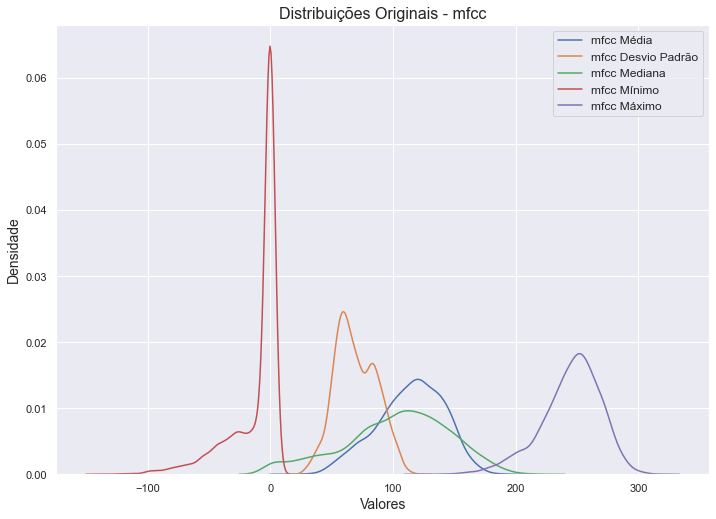

In [17]:
fig, (ax) = plt.subplots(ncols=1)
ax.set_title('Distribuições Originais - mfcc', fontsize=16)
ax.set_xlabel("Valores", fontsize=14)
ax.set_ylabel('Densidade', fontsize=14)

sns.kdeplot(X_train[("mfcc", "mean", "2")], ax=ax, label= "mfcc Média")
sns.kdeplot(X_train[("mfcc", "std", "2")], ax=ax, label= "mfcc Desvio Padrão")
sns.kdeplot(X_train[("mfcc", "median", "2")], ax=ax, label= "mfcc Mediana")
sns.kdeplot(X_train[("mfcc", "min", "2")], ax=ax, label= "mfcc Mínimo")
sns.kdeplot(X_train[("mfcc", "max", "2")], ax=ax, label= "mfcc Máximo")

plt.legend(loc="best", fontsize=12)

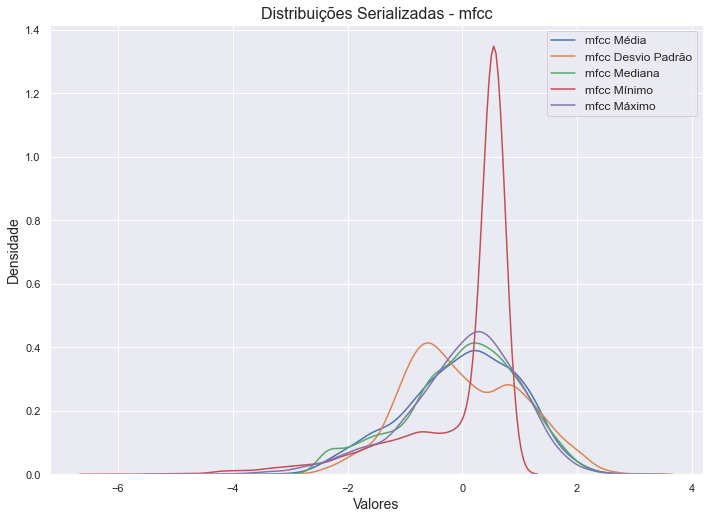

In [18]:
df = pd.DataFrame(columns=X_train.columns, data=X_scaled)

fig, (ax) = plt.subplots(ncols=1)
ax.set_title('Distribuições Escalonadas - mfcc', fontsize=16)
ax.set_xlabel("Valores", fontsize=14)
ax.set_ylabel('Densidade', fontsize=14)

sns.kdeplot(df[("mfcc", "mean", "2")], ax=ax, label= "mfcc Média")
sns.kdeplot(df[("mfcc", "std", "2")], ax=ax, label= "mfcc Desvio Padrão")
sns.kdeplot(df[("mfcc", "median", "2")], ax=ax, label= "mfcc Mediana")
sns.kdeplot(df[("mfcc", "min", "2")], ax=ax, label= "mfcc Mínimo")
sns.kdeplot(df[("mfcc", "max", "2")], ax=ax, label= "mfcc Máximo")

plt.legend(loc="best", fontsize=12)

In [19]:
def graphByGridSearchCVResult(cv_results, params, x_param_var, x_param_label, title):
    '''
    Método para criar gráficos dos resultados do método GridSearchCV. Um dos parametros de busca é usado como x,
    os outros são usados como pontos e o eixo y é a média das acurácias
    
    Parametros:
    params = Dicionario com os parametrós usados na busca
    x_param_var = Nome do parametro do dicionario que será usado no eixo x do gráfico
    x_param_label = Label para o eixo x
    title = título do gráfico
    '''
    _, ax = plt.subplots(1,1)

    x_count = len(params[x_param_var])
    index_params = 0
    
    dict_labels = {}
    while index_params < len(cv_results['params']):
        aux_count = 0
        while aux_count < x_count:
            label = ""
            for param, value in cv_results['params'][index_params].items():
                if x_param_var != param:
                    label = label + param + " = " + str(value) + ";"
            if not label in dict_labels:
                dict_labels[label] = []
            dict_labels[label].append(cv_results['mean_test_score'][index_params])
            aux_count += 1
            index_params += 1
    print(dict_labels)
    for label, values in dict_labels.items():
        ax.plot(params[x_param_var], values, '-o', label= label)

    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel(x_param_label, fontsize=14)
    ax.set_ylabel('Precisão Média', fontsize=14)
    
    if len(dict_labels) > 1:
        ax.legend(loc="best", fontsize=12)
        
    ax.grid('on')

# Tests with GridSearchCV
Foi testado para cada modelo utilizado a melhor otimização para os dados utilizando o metod GridSearchCV

## LogisticRegression

In [20]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = { 'C' : [0.1,0.2,0.3,0.4,0.5,1,2,3,4,5,6,7,8,9,10] }

grid = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=3)
grid.fit(X_scaled, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..........................................C=0.1; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..........................................C=0.1; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..........................................C=0.1; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..........................................C=0.1; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..........................................C=0.1; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..........................................C=0.2; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..........................................C=0.2; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..........................................C=0.2; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..........................................C=0.2; total time=   0.5s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..........................................C=0.2; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..........................................C=0.3; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..........................................C=0.3; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..........................................C=0.3; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..........................................C=0.3; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..........................................C=0.3; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..........................................C=0.4; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..........................................C=0.4; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..........................................C=0.4; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..........................................C=0.4; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..........................................C=0.4; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..........................................C=0.5; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..........................................C=0.5; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..........................................C=0.5; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..........................................C=0.5; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..........................................C=0.5; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................................C=1; total time=   0.8s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................................C=1; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................................C=1; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................................C=1; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............................................C=1; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................................C=2; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................................C=2; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................................C=2; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................................C=2; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............................................C=2; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................................C=3; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................................C=3; total time=   0.8s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................................C=3; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................................C=3; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............................................C=3; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................................C=4; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................................C=4; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................................C=4; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................................C=4; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............................................C=4; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................................C=5; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................................C=5; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................................C=5; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................................C=5; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............................................C=5; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................................C=6; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................................C=6; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................................C=6; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................................C=6; total time=   0.8s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............................................C=6; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................................C=7; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................................C=7; total time=   0.8s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................................C=7; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................................C=7; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............................................C=7; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................................C=8; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................................C=8; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................................C=8; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................................C=8; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............................................C=8; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................................C=9; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................................C=9; total time=   0.6s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................................C=9; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................................C=9; total time=   0.8s
[CV 5/5] END ............................................C=9; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[CV 1/5] END ...........................................C=10; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...........................................C=10; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...........................................C=10; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...........................................C=10; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...........................................C=10; total time=   0.7s


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3, 4, 5, 6, 7, 8,
                               9, 10]},
             scoring='accuracy', verbose=3)

In [21]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.994741,0.002186,{'C': 0.1}
1,0.995909,0.001430,{'C': 0.2}
2,0.995909,0.001430,{'C': 0.3}
3,0.995909,0.001430,{'C': 0.4}
4,0.995909,0.001430,{'C': 0.5}
5,0.996201,0.001168,{'C': 1}
6,0.996494,0.001168,{'C': 2}
7,0.996494,0.001168,{'C': 3}
8,0.996494,0.001168,{'C': 4}
9,0.996494,0.001168,{'C': 5}


In [22]:
grid.best_params_

{'C': 2}

{'': [0.9947406838263542, 0.995909420753831, 0.995909420753831, 0.995909420753831, 0.995909420753831, 0.9962013915567507, 0.9964937892175694, 0.9964937892175694, 0.9964937892175694, 0.9964937892175694, 0.9964937892175694, 0.9964937892175694, 0.9964937892175694, 0.9964937892175694, 0.9964937892175694]}


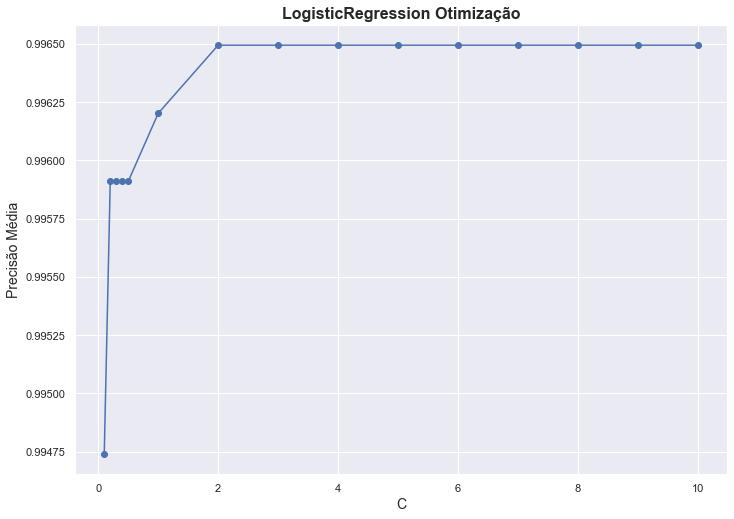

In [23]:
graphByGridSearchCVResult(grid.cv_results_, param_grid, 'C', 'C', "LogisticRegression Otimização")

## RandomForestClassifier

In [24]:
# Mapa de parametros para busca com GridSearchCV
param_grid = {'n_estimators': [50,100, 200, 500,700], 'max_features': ['auto', 'sqrt', 'log2']
              , 'criterion': ['gini', 'entropy']}

#Modulo RandomForestClassifier com 5 cross validations e metodo de avaliação precissão
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=3)
grid.fit(X_scaled, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END criterion=gini, max_features=auto, n_estimators=50; total time=   1.9s
[CV 2/5] END criterion=gini, max_features=auto, n_estimators=50; total time=   1.9s
[CV 3/5] END criterion=gini, max_features=auto, n_estimators=50; total time=   1.8s
[CV 4/5] END criterion=gini, max_features=auto, n_estimators=50; total time=   1.8s
[CV 5/5] END criterion=gini, max_features=auto, n_estimators=50; total time=   1.8s
[CV 1/5] END criterion=gini, max_features=auto, n_estimators=100; total time=   3.7s
[CV 2/5] END criterion=gini, max_features=auto, n_estimators=100; total time=   3.9s
[CV 3/5] END criterion=gini, max_features=auto, n_estimators=100; total time=   3.8s
[CV 4/5] END criterion=gini, max_features=auto, n_estimators=100; total time=   3.7s
[CV 5/5] END criterion=gini, max_features=auto, n_estimators=100; total time=   3.6s
[CV 1/5] END criterion=gini, max_features=auto, n_estimators=200; total time=   7.5s
[CV 2/5]

[CV 2/5] END criterion=entropy, max_features=auto, n_estimators=700; total time= 1.3min
[CV 3/5] END criterion=entropy, max_features=auto, n_estimators=700; total time= 1.3min
[CV 4/5] END criterion=entropy, max_features=auto, n_estimators=700; total time= 1.3min
[CV 5/5] END criterion=entropy, max_features=auto, n_estimators=700; total time= 1.4min
[CV 1/5] END criterion=entropy, max_features=sqrt, n_estimators=50; total time=   5.9s
[CV 2/5] END criterion=entropy, max_features=sqrt, n_estimators=50; total time=   5.8s
[CV 3/5] END criterion=entropy, max_features=sqrt, n_estimators=50; total time=   5.7s
[CV 4/5] END criterion=entropy, max_features=sqrt, n_estimators=50; total time=   5.5s
[CV 5/5] END criterion=entropy, max_features=sqrt, n_estimators=50; total time=   5.7s
[CV 1/5] END criterion=entropy, max_features=sqrt, n_estimators=100; total time=  11.8s
[CV 2/5] END criterion=entropy, max_features=sqrt, n_estimators=100; total time=  11.9s
[CV 3/5] END criterion=entropy, max_f

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 500, 700]},
             scoring='accuracy', verbose=3)

In [25]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.987437,0.003756,"{'criterion': 'gini', 'max_features': 'auto', ..."
1,0.990651,0.003524,"{'criterion': 'gini', 'max_features': 'auto', ..."
2,0.990943,0.003736,"{'criterion': 'gini', 'max_features': 'auto', ..."
3,0.990359,0.003870,"{'criterion': 'gini', 'max_features': 'auto', ..."
4,0.990067,0.003619,"{'criterion': 'gini', 'max_features': 'auto', ..."
5,0.987437,0.003756,"{'criterion': 'gini', 'max_features': 'sqrt', ..."
6,0.990651,0.003524,"{'criterion': 'gini', 'max_features': 'sqrt', ..."
7,0.990943,0.003736,"{'criterion': 'gini', 'max_features': 'sqrt', ..."
8,0.990359,0.003870,"{'criterion': 'gini', 'max_features': 'sqrt', ..."
9,0.990067,0.003619,"{'criterion': 'gini', 'max_features': 'sqrt', ..."


In [26]:
grid.best_params_

{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 200}

{'criterion = gini;max_features = auto;': [0.9874367183164724, 0.9906509582959832, 0.9909433559568018, 0.9903589874930635, 0.9900665898322447], 'criterion = gini;max_features = sqrt;': [0.9874367183164724, 0.9906509582959832, 0.9909433559568018, 0.9903589874930635, 0.9900665898322447], 'criterion = gini;max_features = log2;': [0.9859734494386819, 0.988020233064413, 0.9903585606351644, 0.9909433559568018, 0.9909429290989029], 'criterion = entropy;max_features = auto;': [0.9883130575831306, 0.9906505314380842, 0.9900661629743457, 0.9903585606351644, 0.9903585606351644], 'criterion = entropy;max_features = sqrt;': [0.9883130575831306, 0.9906505314380842, 0.9900661629743457, 0.9903585606351644, 0.9903585606351644], 'criterion = entropy;max_features = log2;': [0.9874367183164725, 0.9883130575831306, 0.9894822213685064, 0.9909429290989029, 0.9906509582959832]}


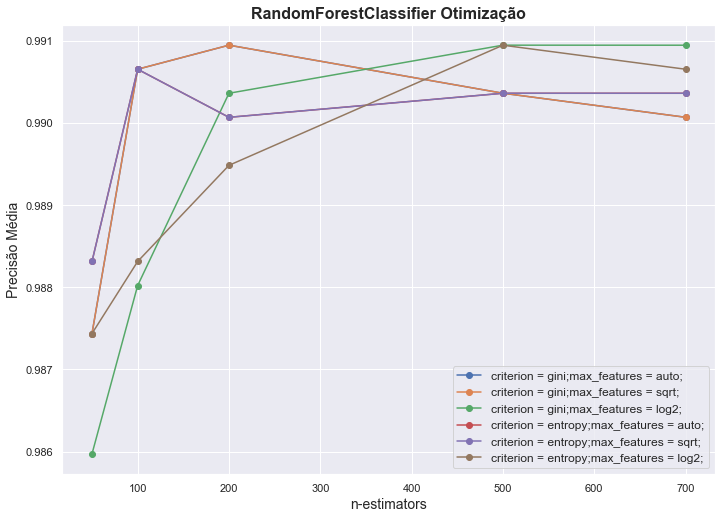

In [27]:
graphByGridSearchCVResult(grid.cv_results_, param_grid, 'n_estimators', 'n-estimators', "RandomForestClassifier Otimização")

## KNeighborsClassifier 

In [28]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = {'n_neighbors': range(1, 30), 'weights' : ['uniform', 'distance']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', verbose=3)
grid.fit(X_scaled, y_train)

Fitting 5 folds for each of 58 candidates, totalling 290 fits
[CV 1/5] END .................n_neighbors=1, weights=uniform; total time=   0.0s
[CV 2/5] END .................n_neighbors=1, weights=uniform; total time=   0.0s
[CV 3/5] END .................n_neighbors=1, weights=uniform; total time=   0.1s
[CV 4/5] END .................n_neighbors=1, weights=uniform; total time=   0.0s
[CV 5/5] END .................n_neighbors=1, weights=uniform; total time=   0.0s
[CV 1/5] END ................n_neighbors=1, weights=distance; total time=   0.0s
[CV 2/5] END ................n_neighbors=1, weights=distance; total time=   0.0s
[CV 3/5] END ................n_neighbors=1, weights=distance; total time=   0.0s
[CV 4/5] END ................n_neighbors=1, weights=distance; total time=   0.0s
[CV 5/5] END ................n_neighbors=1, weights=distance; total time=   0.0s
[CV 1/5] END .................n_neighbors=2, weights=uniform; total time=   0.0s
[CV 2/5] END .................n_neighbors=2, we

[CV 4/5] END ................n_neighbors=11, weights=uniform; total time=   0.0s
[CV 5/5] END ................n_neighbors=11, weights=uniform; total time=   0.0s
[CV 1/5] END ...............n_neighbors=11, weights=distance; total time=   0.0s
[CV 2/5] END ...............n_neighbors=11, weights=distance; total time=   0.0s
[CV 3/5] END ...............n_neighbors=11, weights=distance; total time=   0.0s
[CV 4/5] END ...............n_neighbors=11, weights=distance; total time=   0.0s
[CV 5/5] END ...............n_neighbors=11, weights=distance; total time=   0.0s
[CV 1/5] END ................n_neighbors=12, weights=uniform; total time=   0.0s
[CV 2/5] END ................n_neighbors=12, weights=uniform; total time=   0.0s
[CV 3/5] END ................n_neighbors=12, weights=uniform; total time=   0.0s
[CV 4/5] END ................n_neighbors=12, weights=uniform; total time=   0.0s
[CV 5/5] END ................n_neighbors=12, weights=uniform; total time=   0.0s
[CV 1/5] END ...............

[CV 1/5] END ...............n_neighbors=21, weights=distance; total time=   0.0s
[CV 2/5] END ...............n_neighbors=21, weights=distance; total time=   0.0s
[CV 3/5] END ...............n_neighbors=21, weights=distance; total time=   0.0s
[CV 4/5] END ...............n_neighbors=21, weights=distance; total time=   0.0s
[CV 5/5] END ...............n_neighbors=21, weights=distance; total time=   0.0s
[CV 1/5] END ................n_neighbors=22, weights=uniform; total time=   0.0s
[CV 2/5] END ................n_neighbors=22, weights=uniform; total time=   0.0s
[CV 3/5] END ................n_neighbors=22, weights=uniform; total time=   0.0s
[CV 4/5] END ................n_neighbors=22, weights=uniform; total time=   0.0s
[CV 5/5] END ................n_neighbors=22, weights=uniform; total time=   0.0s
[CV 1/5] END ...............n_neighbors=22, weights=distance; total time=   0.0s
[CV 2/5] END ...............n_neighbors=22, weights=distance; total time=   0.0s
[CV 3/5] END ...............

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=3)

In [29]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.994158,0.004428,"{'n_neighbors': 1, 'weights': 'uniform'}"
1,0.994158,0.004428,"{'n_neighbors': 1, 'weights': 'distance'}"
2,0.992988,0.003249,"{'n_neighbors': 2, 'weights': 'uniform'}"
3,0.994158,0.004428,"{'n_neighbors': 2, 'weights': 'distance'}"
4,0.992696,0.003327,"{'n_neighbors': 3, 'weights': 'uniform'}"
5,0.993573,0.003004,"{'n_neighbors': 3, 'weights': 'distance'}"
6,0.992404,0.003114,"{'n_neighbors': 4, 'weights': 'uniform'}"
7,0.994449,0.002335,"{'n_neighbors': 4, 'weights': 'distance'}"
8,0.991235,0.002766,"{'n_neighbors': 5, 'weights': 'uniform'}"
9,0.991235,0.002766,"{'n_neighbors': 5, 'weights': 'distance'}"


In [30]:
grid.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

{'weights = uniform;': [0.9941575959363128, 0.992988432150937, 0.9926960344901182, 0.9924040636871985, 0.9912348999018226, 0.9912353267597217, 0.9894822213685064, 0.986851069279037, 0.9836368292995262, 0.9842220514790625, 0.981591753105391, 0.9789614547317198, 0.9792538523925387, 0.977793144662142, 0.9780846886071629, 0.9783766594100826, 0.9775007470013233, 0.9766244077346652, 0.9763320100738465, 0.9754552439492894, 0.9742865070218123, 0.9737012848422761, 0.9734093140393563, 0.9722405771118796, 0.972532547914799, 0.9701955009177444, 0.969610705596107, 0.9672728048832543, 0.9661032142399796], 'weights = distance;': [0.9941575959363128, 0.9941575959363128, 0.9935728006146753, 0.9944487130234345, 0.9912348999018226, 0.9921120928842788, 0.989774192171426, 0.9891893968497886, 0.9850979638878217, 0.9850988176036198, 0.9830533145515858, 0.9804230161779144, 0.9804230161779144, 0.9795466769112562, 0.9786694839287999, 0.9786690570709012, 0.9780855423229606, 0.9775011738592223, 0.9775011738592223

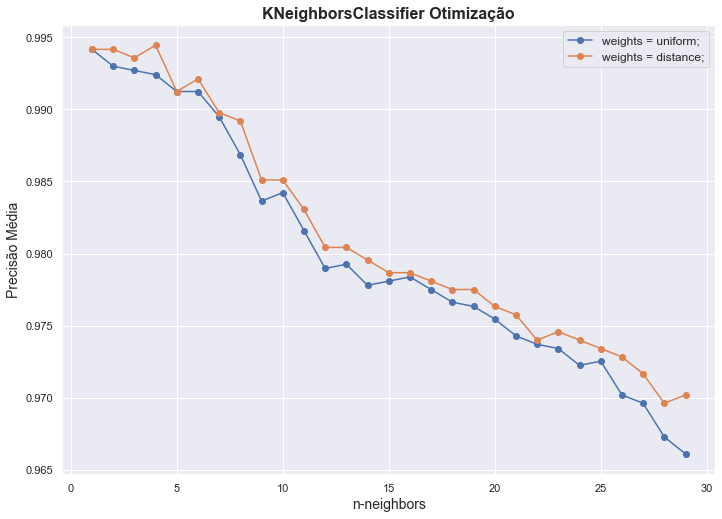

In [31]:
graphByGridSearchCVResult(grid.cv_results_, param_grid, 'n_neighbors', 'n-neighbors', "KNeighborsClassifier Otimização")

## DecisionTreeClassifier

In [32]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
              , 'min_samples_split': [2, 3, 4]}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=3)
grid.fit(X_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END criterion=gini, max_depth=4, min_samples_split=2; total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=4, min_samples_split=2; total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=4, min_samples_split=2; total time=   0.4s
[CV 4/5] END criterion=gini, max_depth=4, min_samples_split=2; total time=   0.3s
[CV 5/5] END criterion=gini, max_depth=4, min_samples_split=2; total time=   0.3s
[CV 1/5] END criterion=gini, max_depth=4, min_samples_split=3; total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=4, min_samples_split=3; total time=   0.4s
[CV 3/5] END criterion=gini, max_depth=4, min_samples_split=3; total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=4, min_samples_split=3; total time=   0.3s
[CV 5/5] END criterion=gini, max_depth=4, min_samples_split=3; total time=   0.4s
[CV 1/5] END criterion=gini, max_depth=4, min_samples_split=4; total time=   0.3s
[CV 2/5] END criterion=gini, max_de

[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=4; total time=   0.7s
[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=4; total time=   0.9s
[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=4; total time=   0.7s
[CV 4/5] END criterion=gini, max_depth=10, min_samples_split=4; total time=   0.8s
[CV 5/5] END criterion=gini, max_depth=10, min_samples_split=4; total time=   0.8s
[CV 1/5] END criterion=gini, max_depth=11, min_samples_split=2; total time=   0.8s
[CV 2/5] END criterion=gini, max_depth=11, min_samples_split=2; total time=   0.8s
[CV 3/5] END criterion=gini, max_depth=11, min_samples_split=2; total time=   0.8s
[CV 4/5] END criterion=gini, max_depth=11, min_samples_split=2; total time=   0.9s
[CV 5/5] END criterion=gini, max_depth=11, min_samples_split=2; total time=   0.9s
[CV 1/5] END criterion=gini, max_depth=11, min_samples_split=3; total time=   0.7s
[CV 2/5] END criterion=gini, max_depth=11, min_samples_split=3; total time=   0.8s
[CV 

[CV 5/5] END criterion=gini, max_depth=50, min_samples_split=2; total time=   0.9s
[CV 1/5] END criterion=gini, max_depth=50, min_samples_split=3; total time=   0.8s
[CV 2/5] END criterion=gini, max_depth=50, min_samples_split=3; total time=   0.9s
[CV 3/5] END criterion=gini, max_depth=50, min_samples_split=3; total time=   0.8s
[CV 4/5] END criterion=gini, max_depth=50, min_samples_split=3; total time=   1.1s
[CV 5/5] END criterion=gini, max_depth=50, min_samples_split=3; total time=   0.9s
[CV 1/5] END criterion=gini, max_depth=50, min_samples_split=4; total time=   0.8s
[CV 2/5] END criterion=gini, max_depth=50, min_samples_split=4; total time=   0.9s
[CV 3/5] END criterion=gini, max_depth=50, min_samples_split=4; total time=   0.9s
[CV 4/5] END criterion=gini, max_depth=50, min_samples_split=4; total time=   1.0s
[CV 5/5] END criterion=gini, max_depth=50, min_samples_split=4; total time=   1.0s
[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=2; total time=   0.9s
[CV 

[CV 3/5] END criterion=entropy, max_depth=5, min_samples_split=4; total time=   2.0s
[CV 4/5] END criterion=entropy, max_depth=5, min_samples_split=4; total time=   2.0s
[CV 5/5] END criterion=entropy, max_depth=5, min_samples_split=4; total time=   2.0s
[CV 1/5] END criterion=entropy, max_depth=6, min_samples_split=2; total time=   2.2s
[CV 2/5] END criterion=entropy, max_depth=6, min_samples_split=2; total time=   2.2s
[CV 3/5] END criterion=entropy, max_depth=6, min_samples_split=2; total time=   2.2s
[CV 4/5] END criterion=entropy, max_depth=6, min_samples_split=2; total time=   2.2s
[CV 5/5] END criterion=entropy, max_depth=6, min_samples_split=2; total time=   2.2s
[CV 1/5] END criterion=entropy, max_depth=6, min_samples_split=3; total time=   2.3s
[CV 2/5] END criterion=entropy, max_depth=6, min_samples_split=3; total time=   2.1s
[CV 3/5] END criterion=entropy, max_depth=6, min_samples_split=3; total time=   2.1s
[CV 4/5] END criterion=entropy, max_depth=6, min_samples_split=3;

[CV 4/5] END criterion=entropy, max_depth=12, min_samples_split=2; total time=   2.3s
[CV 5/5] END criterion=entropy, max_depth=12, min_samples_split=2; total time=   2.3s
[CV 1/5] END criterion=entropy, max_depth=12, min_samples_split=3; total time=   2.4s
[CV 2/5] END criterion=entropy, max_depth=12, min_samples_split=3; total time=   2.3s
[CV 3/5] END criterion=entropy, max_depth=12, min_samples_split=3; total time=   2.3s
[CV 4/5] END criterion=entropy, max_depth=12, min_samples_split=3; total time=   2.3s
[CV 5/5] END criterion=entropy, max_depth=12, min_samples_split=3; total time=   2.3s
[CV 1/5] END criterion=entropy, max_depth=12, min_samples_split=4; total time=   2.4s
[CV 2/5] END criterion=entropy, max_depth=12, min_samples_split=4; total time=   2.3s
[CV 3/5] END criterion=entropy, max_depth=12, min_samples_split=4; total time=   2.3s
[CV 4/5] END criterion=entropy, max_depth=12, min_samples_split=4; total time=   2.3s
[CV 5/5] END criterion=entropy, max_depth=12, min_samp

[CV 5/5] END criterion=entropy, max_depth=70, min_samples_split=3; total time=   2.3s
[CV 1/5] END criterion=entropy, max_depth=70, min_samples_split=4; total time=   2.4s
[CV 2/5] END criterion=entropy, max_depth=70, min_samples_split=4; total time=   2.3s
[CV 3/5] END criterion=entropy, max_depth=70, min_samples_split=4; total time=   2.4s
[CV 4/5] END criterion=entropy, max_depth=70, min_samples_split=4; total time=   2.3s
[CV 5/5] END criterion=entropy, max_depth=70, min_samples_split=4; total time=   2.3s
[CV 1/5] END criterion=entropy, max_depth=90, min_samples_split=2; total time=   2.4s
[CV 2/5] END criterion=entropy, max_depth=90, min_samples_split=2; total time=   2.3s
[CV 3/5] END criterion=entropy, max_depth=90, min_samples_split=2; total time=   2.3s
[CV 4/5] END criterion=entropy, max_depth=90, min_samples_split=2; total time=   2.3s
[CV 5/5] END criterion=entropy, max_depth=90, min_samples_split=2; total time=   2.3s
[CV 1/5] END criterion=entropy, max_depth=90, min_samp

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150],
                         'min_samples_split': [2, 3, 4]},
             scoring='accuracy', verbose=3)

In [33]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.227634,0.024894,"{'criterion': 'gini', 'max_depth': 4, 'min_sam..."
1,0.227634,0.024894,"{'criterion': 'gini', 'max_depth': 4, 'min_sam..."
2,0.227634,0.024894,"{'criterion': 'gini', 'max_depth': 4, 'min_sam..."
3,0.307995,0.041984,"{'criterion': 'gini', 'max_depth': 5, 'min_sam..."
4,0.307995,0.041984,"{'criterion': 'gini', 'max_depth': 5, 'min_sam..."
...,...,...,...
103,0.870257,0.015457,"{'criterion': 'entropy', 'max_depth': 120, 'mi..."
104,0.877269,0.010851,"{'criterion': 'entropy', 'max_depth': 120, 'mi..."
105,0.871135,0.019671,"{'criterion': 'entropy', 'max_depth': 150, 'mi..."
106,0.870257,0.015457,"{'criterion': 'entropy', 'max_depth': 150, 'mi..."


In [34]:
grid.best_params_

{'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 4}

{'criterion = gini;min_samples_split = 2;': [0.22763392666581295, 0.3079954753062705, 0.38748751440645407, 0.47252955990950607, 0.5479318734793187, 0.6204059418619542, 0.6642322960686389, 0.7016378537584839, 0.7378738208050539, 0.822912451444914, 0.8384035514577197, 0.8424979724249797, 0.841328381781705, 0.841328381781705, 0.841328381781705, 0.841328381781705, 0.841328381781705, 0.841328381781705], 'criterion = gini;min_samples_split = 3;': [0.22763392666581295, 0.3079954753062705, 0.38748751440645407, 0.47311350151534554, 0.5514363768301533, 0.6204059418619541, 0.6642314423528407, 0.7030968540572843, 0.7437183591582361, 0.8138502582490288, 0.838111153796901, 0.8398638323302172, 0.8422030136167671, 0.8422030136167671, 0.8422030136167671, 0.8422030136167671, 0.8422030136167671, 0.8422030136167671], 'criterion = gini;min_samples_split = 4;': [0.22763392666581295, 0.3079954753062705, 0.388656251333931, 0.4704832031416741, 0.5502676399026764, 0.6233277841806463, 0.6654031672856106, 0.69725

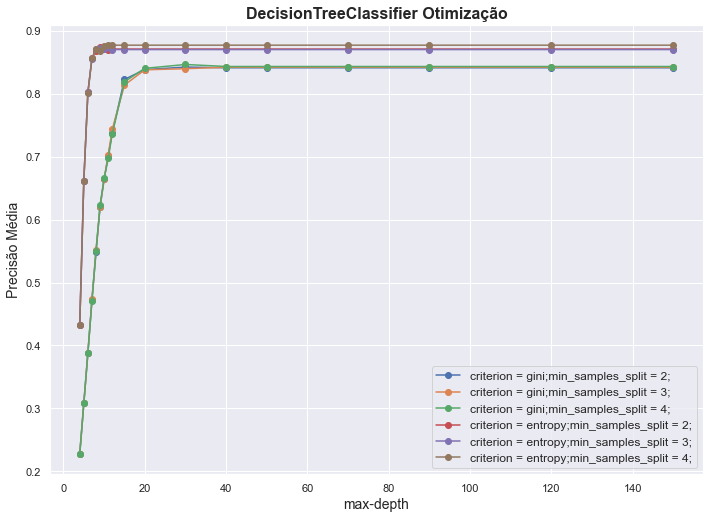

In [35]:
graphByGridSearchCVResult(grid.cv_results_, param_grid, 'max_depth', 'max-depth', "DecisionTreeClassifier Otimização")

## SVC

In [36]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = {'C': np.arange(0.5, 5.5, 0.5), 'kernel': ['linear','rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=3)
grid.fit(X_scaled, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ...........................C=0.5, kernel=linear; total time=   0.3s
[CV 2/5] END ...........................C=0.5, kernel=linear; total time=   0.3s
[CV 3/5] END ...........................C=0.5, kernel=linear; total time=   0.3s
[CV 4/5] END ...........................C=0.5, kernel=linear; total time=   0.3s
[CV 5/5] END ...........................C=0.5, kernel=linear; total time=   0.3s
[CV 1/5] END ..............................C=0.5, kernel=rbf; total time=   0.9s
[CV 2/5] END ..............................C=0.5, kernel=rbf; total time=   0.9s
[CV 3/5] END ..............................C=0.5, kernel=rbf; total time=   0.9s
[CV 4/5] END ..............................C=0.5, kernel=rbf; total time=   0.9s
[CV 5/5] END ..............................C=0.5, kernel=rbf; total time=   0.9s
[CV 1/5] END .............................C=0.5, kernel=poly; total time=   0.7s
[CV 2/5] END .............................C=0.5

[CV 2/5] END ...........................C=3.0, kernel=linear; total time=   0.3s
[CV 3/5] END ...........................C=3.0, kernel=linear; total time=   0.3s
[CV 4/5] END ...........................C=3.0, kernel=linear; total time=   0.3s
[CV 5/5] END ...........................C=3.0, kernel=linear; total time=   0.3s
[CV 1/5] END ..............................C=3.0, kernel=rbf; total time=   0.9s
[CV 2/5] END ..............................C=3.0, kernel=rbf; total time=   0.9s
[CV 3/5] END ..............................C=3.0, kernel=rbf; total time=   0.9s
[CV 4/5] END ..............................C=3.0, kernel=rbf; total time=   0.9s
[CV 5/5] END ..............................C=3.0, kernel=rbf; total time=   0.9s
[CV 1/5] END .............................C=3.0, kernel=poly; total time=   0.6s
[CV 2/5] END .............................C=3.0, kernel=poly; total time=   0.7s
[CV 3/5] END .............................C=3.0, kernel=poly; total time=   0.6s
[CV 4/5] END ...............

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=3)

In [37]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.998248,0.001702,"{'C': 0.5, 'kernel': 'linear'}"
1,0.992111,0.002183,"{'C': 0.5, 'kernel': 'rbf'}"
2,0.931912,0.007811,"{'C': 0.5, 'kernel': 'poly'}"
3,0.990942,0.002511,"{'C': 0.5, 'kernel': 'sigmoid'}"
4,0.998248,0.001702,"{'C': 1.0, 'kernel': 'linear'}"
5,0.994450,0.003502,"{'C': 1.0, 'kernel': 'rbf'}"
6,0.962889,0.007812,"{'C': 1.0, 'kernel': 'poly'}"
7,0.991818,0.003007,"{'C': 1.0, 'kernel': 'sigmoid'}"
8,0.998248,0.001702,"{'C': 1.5, 'kernel': 'linear'}"
9,0.996495,0.002184,"{'C': 1.5, 'kernel': 'rbf'}"


In [38]:
grid.best_params_

{'C': 0.5, 'kernel': 'linear'}

{'kernel = linear;': [0.9982477483245826, 0.9982477483245826, 0.9982477483245826, 0.9982477483245826, 0.9982477483245826, 0.9982477483245826, 0.9982477483245826, 0.9982477483245826, 0.9982477483245826, 0.9982477483245826], 'kernel = rbf;': [0.9921108123105817, 0.9944499935971315, 0.9964946429333675, 0.9967866137362872, 0.9967866137362872, 0.9967866137362872, 0.9967866137362872, 0.9967866137362872, 0.9967866137362872, 0.9967866137362872], 'kernel = poly;': [0.9319123233875443, 0.9628894011183677, 0.9737017117001748, 0.9772092030563024, 0.9789623084475177, 0.9818841507662099, 0.9821761215691296, 0.9824680923720495, 0.9827600631749691, 0.9833444316387074], 'kernel = sigmoid;': [0.9909416485252059, 0.9918184146497631, 0.9929871515772399, 0.9918184146497632, 0.9903577069193664, 0.9897733384556281, 0.9891881162760917, 0.9888965723310708, 0.9886050283860502, 0.9888978529047678]}


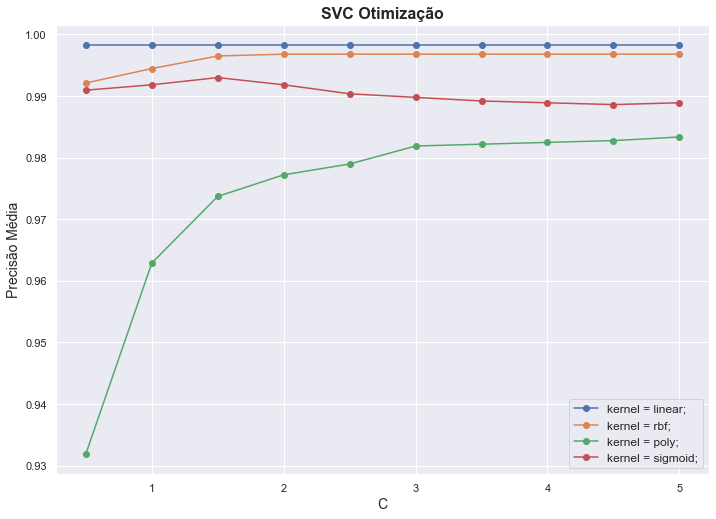

In [39]:
graphByGridSearchCVResult(grid.cv_results_, param_grid, 'C', 'C', "SVC Otimização")

## GaussianNB

In [40]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

grid = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='accuracy', verbose=3)
grid.fit(X_scaled, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ..............................var_smoothing=1.0; total time=   0.0s
[CV 2/5] END ..............................var_smoothing=1.0; total time=   0.0s
[CV 3/5] END ..............................var_smoothing=1.0; total time=   0.0s
[CV 4/5] END ..............................var_smoothing=1.0; total time=   0.0s
[CV 5/5] END ..............................var_smoothing=1.0; total time=   0.0s
[CV 1/5] END ...............var_smoothing=0.8111308307896871; total time=   0.0s
[CV 2/5] END ...............var_smoothing=0.8111308307896871; total time=   0.0s
[CV 3/5] END ...............var_smoothing=0.8111308307896871; total time=   0.0s
[CV 4/5] END ...............var_smoothing=0.8111308307896871; total time=   0.0s
[CV 5/5] END ...............var_smoothing=0.8111308307896871; total time=   0.0s
[CV 1/5] END ................var_smoothing=0.657933224657568; total time=   0.0s
[CV 2/5] END ................var_smoothing=0.6

[CV 4/5] END ..............var_smoothing=0.01519911082952933; total time=   0.0s
[CV 5/5] END ..............var_smoothing=0.01519911082952933; total time=   0.0s
[CV 1/5] END .............var_smoothing=0.012328467394420659; total time=   0.0s
[CV 2/5] END .............var_smoothing=0.012328467394420659; total time=   0.0s
[CV 3/5] END .............var_smoothing=0.012328467394420659; total time=   0.0s
[CV 4/5] END .............var_smoothing=0.012328467394420659; total time=   0.0s
[CV 5/5] END .............var_smoothing=0.012328467394420659; total time=   0.0s
[CV 1/5] END .............................var_smoothing=0.01; total time=   0.0s
[CV 2/5] END .............................var_smoothing=0.01; total time=   0.0s
[CV 3/5] END .............................var_smoothing=0.01; total time=   0.0s
[CV 4/5] END .............................var_smoothing=0.01; total time=   0.0s
[CV 5/5] END .............................var_smoothing=0.01; total time=   0.0s
[CV 1/5] END .............va

[CV 1/5] END ............var_smoothing=0.0001873817422860383; total time=   0.0s
[CV 2/5] END ............var_smoothing=0.0001873817422860383; total time=   0.0s
[CV 3/5] END ............var_smoothing=0.0001873817422860383; total time=   0.0s
[CV 4/5] END ............var_smoothing=0.0001873817422860383; total time=   0.0s
[CV 5/5] END ............var_smoothing=0.0001873817422860383; total time=   0.0s
[CV 1/5] END ............var_smoothing=0.0001519911082952933; total time=   0.0s
[CV 2/5] END ............var_smoothing=0.0001519911082952933; total time=   0.0s
[CV 3/5] END ............var_smoothing=0.0001519911082952933; total time=   0.0s
[CV 4/5] END ............var_smoothing=0.0001519911082952933; total time=   0.0s
[CV 5/5] END ............var_smoothing=0.0001519911082952933; total time=   0.0s
[CV 1/5] END ............var_smoothing=0.0001232846739442066; total time=   0.0s
[CV 2/5] END ............var_smoothing=0.0001232846739442066; total time=   0.0s
[CV 3/5] END ............var

[CV 5/5] END ............var_smoothing=2.848035868435799e-06; total time=   0.0s
[CV 1/5] END ............var_smoothing=2.310129700083158e-06; total time=   0.0s
[CV 2/5] END ............var_smoothing=2.310129700083158e-06; total time=   0.0s
[CV 3/5] END ............var_smoothing=2.310129700083158e-06; total time=   0.0s
[CV 4/5] END ............var_smoothing=2.310129700083158e-06; total time=   0.0s
[CV 5/5] END ............var_smoothing=2.310129700083158e-06; total time=   0.0s
[CV 1/5] END ............var_smoothing=1.873817422860383e-06; total time=   0.0s
[CV 2/5] END ............var_smoothing=1.873817422860383e-06; total time=   0.0s
[CV 3/5] END ............var_smoothing=1.873817422860383e-06; total time=   0.0s
[CV 4/5] END ............var_smoothing=1.873817422860383e-06; total time=   0.0s
[CV 5/5] END ............var_smoothing=1.873817422860383e-06; total time=   0.0s
[CV 1/5] END ............var_smoothing=1.519911082952933e-06; total time=   0.0s
[CV 2/5] END ............var

[CV 2/5] END ...........var_smoothing=3.5111917342151277e-08; total time=   0.0s
[CV 3/5] END ...........var_smoothing=3.5111917342151277e-08; total time=   0.0s
[CV 4/5] END ...........var_smoothing=3.5111917342151277e-08; total time=   0.0s
[CV 5/5] END ...........var_smoothing=3.5111917342151277e-08; total time=   0.0s
[CV 1/5] END ............var_smoothing=2.848035868435799e-08; total time=   0.0s
[CV 2/5] END ............var_smoothing=2.848035868435799e-08; total time=   0.0s
[CV 3/5] END ............var_smoothing=2.848035868435799e-08; total time=   0.0s
[CV 4/5] END ............var_smoothing=2.848035868435799e-08; total time=   0.0s
[CV 5/5] END ............var_smoothing=2.848035868435799e-08; total time=   0.0s
[CV 1/5] END ............var_smoothing=2.310129700083158e-08; total time=   0.0s
[CV 2/5] END ............var_smoothing=2.310129700083158e-08; total time=   0.0s
[CV 3/5] END ............var_smoothing=2.310129700083158e-08; total time=   0.0s
[CV 4/5] END ............var

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy', verbose=3)

In [41]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.944185,0.002969,{'var_smoothing': 1.0}
1,0.946815,0.003281,{'var_smoothing': 0.8111308307896871}
2,0.949153,0.002512,{'var_smoothing': 0.657933224657568}
3,0.953828,0.003532,{'var_smoothing': 0.533669923120631}
4,0.956458,0.002838,{'var_smoothing': 0.43287612810830584}
...,...,...,...
95,0.951490,0.007867,{'var_smoothing': 2.310129700083158e-09}
96,0.951490,0.007867,{'var_smoothing': 1.873817422860387e-09}
97,0.951198,0.008142,{'var_smoothing': 1.519911082952933e-09}
98,0.951198,0.008142,{'var_smoothing': 1.2328467394420635e-09}


In [42]:
grid.best_params_

{'var_smoothing': 0.01519911082952933}

{'': [0.9441853416997482, 0.9468147863576215, 0.9491526870704743, 0.9538280616382806, 0.956457933154053, 0.958504289921885, 0.9602573953131003, 0.9614248516668802, 0.9634703547189141, 0.9649319161651085, 0.965517138344645, 0.965517138344645, 0.9663934776113032, 0.966685875272122, 0.965517138344645, 0.9655175652025442, 0.9658091091475647, 0.9649331967388056, 0.9658095360054638, 0.9666863021300209, 0.9675630682545779, 0.9666858752721218, 0.965516284628847, 0.9655158577709481, 0.9652234601101293, 0.9652234601101293, 0.9646390916463907, 0.9640547231826524, 0.964346693985572, 0.964346693985572, 0.964346693985572, 0.9637623255218337, 0.9631779570580953, 0.9625931617364578, 0.9625931617364578, 0.9620087932727195, 0.9617163956119008, 0.9617163956119008, 0.9620087932727195, 0.9620087932727195, 0.9617168224697998, 0.9617168224697998, 0.9611328808639603, 0.9608409100610406, 0.9602565415973021, 0.9599645707943825, 0.9599645707943825, 0.9599645707943825, 0.9599645707943825, 0.959672173133564, 0.959

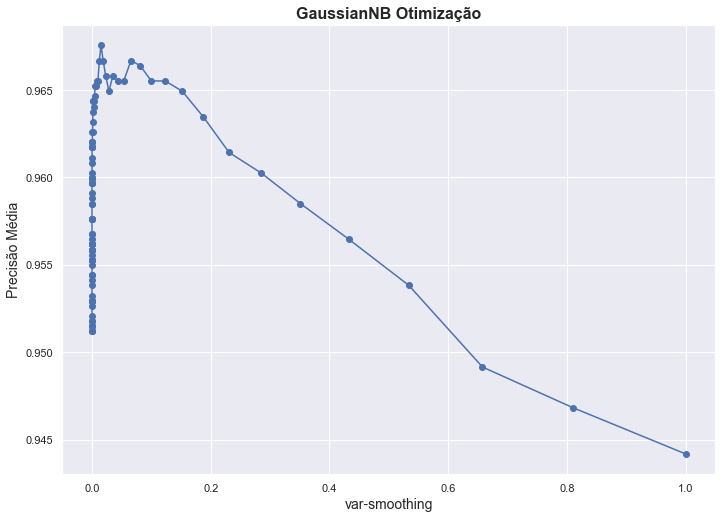

In [43]:
graphByGridSearchCVResult(grid.cv_results_, param_grid, 'var_smoothing', 'var-smoothing', "GaussianNB Otimização")

# CROSS-VALIDATION (DEFAULT X IMPROVE)
Comparação com validação cruzada os parametros padrões de cada modelo e otimizados pela busca com GridSearchCV

## LogisticRegression

In [44]:
#default
clf = LogisticRegression(random_state = 42)
print("LogisticRegression \naccuracy: %f" % cross_val_score(clf, X_scaled, y_train, cv=5).mean())

#improve
clf = LogisticRegression(random_state = 42, C = 8)
print("LogisticRegression \naccuracy: %f" % cross_val_score(clf, X_scaled, y_train, cv=5).mean())

C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression 
accuracy: 0.996201


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression 
accuracy: 0.996494


C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## RandomForestClassifier

In [45]:
#default
clf = RandomForestClassifier(random_state=42)
print("RandomForestClassifier \naccuracy: %f" % cross_val_score(clf, X_scaled, y_train, cv=5).mean())

#improve
clf = RandomForestClassifier(criterion = "gini", max_features = "auto", n_estimators = 500, random_state=42)
print("RandomForestClassifier \naccuracy: %f" % cross_val_score(clf, X_scaled, y_train, cv=5).mean())

RandomForestClassifier 
accuracy: 0.990651
RandomForestClassifier 
accuracy: 0.990359


## KNeighborsClassifier

In [46]:
#default
clf = KNeighborsClassifier()
print("KNeighborsClassifier \naccuracy: %f" % cross_val_score(clf, X_scaled, y_train, cv=5).mean())

#improve
clf = KNeighborsClassifier(n_neighbors=1, weights='uniform')
print("KNeighborsClassifier \naccuracy: %f" % cross_val_score(clf, X_scaled, y_train, cv=5).mean())

KNeighborsClassifier 
accuracy: 0.991235
KNeighborsClassifier 
accuracy: 0.994158


## DecisionTreeClassifier

In [47]:
#default
clf = DecisionTreeClassifier(random_state=42)
print("DecisionTreeClassifier \naccuracy: %f" % cross_val_score(clf, X_scaled, y_train, cv=5).mean())

#improve
clf = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=12, min_samples_split = 3)
print("KNeighborsClassifier \naccuracy: %f" % cross_val_score(clf, X_scaled, y_train, cv=5).mean())

DecisionTreeClassifier 
accuracy: 0.841328
KNeighborsClassifier 
accuracy: 0.870257


## SVC

In [48]:
#default
clf = SVC(random_state=42)
print("SVC \naccuracy: %f" % cross_val_score(clf, X_scaled, y_train, cv=5).mean())

#improve
clf = SVC(random_state=42, C=0.5, kernel='linear')
print("SVC \naccuracy: %f" % cross_val_score(clf, X_scaled, y_train, cv=5).mean())

SVC 
accuracy: 0.994450
SVC 
accuracy: 0.998248


## GaussianNB

In [49]:
#default
clf = GaussianNB()
print("GaussianNB \naccuracy: %f" % cross_val_score(clf, X_scaled, y_train, cv=5).mean())

#improve
clf = GaussianNB(var_smoothing=0.0533669923120631)
print("GaussianNB \naccuracy: %f" % cross_val_score(clf, X_scaled, y_train, cv=5).mean())

GaussianNB 
accuracy: 0.951198
GaussianNB 
accuracy: 0.965517


In [50]:
def models_process(X, y, X_test = None, y_test = None):
    '''
    Método com os models com parametros otimizados pelo GridSearchCV
    Calcula a acuracia dos dados de treino e teste caso enviados, imprimindo na tela os resultados para cada model
    também calcula o tempo de treinamento para cada model
    '''
    start_time = time.time()
    clf = LogisticRegression(random_state = 42, C = 8).fit(X, y)
    print("Time: %fs" % (time.time() - start_time))
    print("LogisticRegression Train \naccuracy: %f" % accuracy_score(y, clf.predict(X)))
    
    if not X_test is None:
        print("LogisticRegression Test \naccuracy: %f" % accuracy_score(y_test, clf.predict(X_test)))
    
    start_time = time.time()
    regr = RandomForestClassifier(criterion = "gini", max_features = "auto", n_estimators = 500, random_state=42).fit(X, y)
    print("Time: %fs" % (time.time() - start_time))
    print("RandomForestClassifier Train \naccuracy: %f" % accuracy_score(y, regr.predict(X)))
    
    if not X_test is None:
        print("RandomForestClassifier Test \naccuracy: %f" % accuracy_score(y_test, regr.predict(X_test)))
    
    start_time = time.time()
    neigh = KNeighborsClassifier(n_neighbors=1, weights='uniform').fit(X, y)
    print("Time: %fs" % (time.time() - start_time))
    print("KNeighborsClassifier Train \naccuracy: %f" % accuracy_score(y, neigh.predict(X)))
    
    if not X_test is None:
        print("KNeighborsClassifier Test \naccuracy: %f" % accuracy_score(y_test, neigh.predict(X_test)))
    
    start_time = time.time()
    model_dtc = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=12, min_samples_split = 3).fit(X, y)
    print("Time: %fs" % (time.time() - start_time))
    print("DecisionTreeClassifier Train \naccuracy: %f" % accuracy_score(y, model_dtc.predict(X)))
    
    if not X_test is None:
        print("DecisionTreeClassifier Test \naccuracy: %f" % accuracy_score(y_test, model_dtc.predict(X_test)))
                
    start_time = time.time()
    model_svc = SVC(random_state=42, C=0.5, kernel='linear').fit(X, y)
    print("Time: %fs" % (time.time() - start_time))
    print("SVC Train \naccuracy: %f" % accuracy_score(y, model_svc.predict(X)))
    
    if not X_test is None:
        print("SVC Test \naccuracy: %f" % accuracy_score(y_test, model_svc.predict(X_test)))
    
    start_time = time.time()
    clf = GaussianNB(var_smoothing=0.0533669923120631).fit(X, y)
    print("Time: %fs" % (time.time() - start_time))
    print("GaussianNB Train \naccuracy: %f" % accuracy_score(y, clf.predict(X)))
    
    if not X_test is None:
        print("GaussianNB Test \naccuracy: %f" % accuracy_score(y_test, clf.predict(X_test)))

# Testes antes de remoção atributos e Alteração de Escala

In [51]:
#separa novamente os dados de treinamento e teste para verificação das acuracias antes de remover as colunas irrelevantes e correlacionas, e da alteração de escala
X_train, X_test, y_train, y_test = data_split(data_train, test_size=0.33, random_state=42, min_examples = 100, limit_example = 130)

## Antes remoção de Correlacionados

In [52]:
models_process(X_train, y_train, X_test, y_test)

C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Time: 1.145902s
LogisticRegression Train 
accuracy: 0.771186
LogisticRegression Test 
accuracy: 0.745950
Time: 27.426803s
RandomForestClassifier Train 
accuracy: 1.000000
RandomForestClassifier Test 
accuracy: 0.991900
Time: 0.010113s
KNeighborsClassifier Train 
accuracy: 1.000000
KNeighborsClassifier Test 
accuracy: 0.724595
Time: 4.191402s
DecisionTreeClassifier Train 
accuracy: 0.994740
DecisionTreeClassifier Test 
accuracy: 0.885125
Time: 0.919620s
SVC Train 
accuracy: 1.000000
SVC Test 
accuracy: 0.959499
Time: 0.083005s
GaussianNB Train 
accuracy: 0.461134
GaussianNB Test 
accuracy: 0.458027


## Antes remoção de Irrelevantes

In [53]:
#remover correlacionados
X_train = X_train.drop(corr_cols, axis=1)
X_test = X_test.drop(corr_cols, axis=1)

models_process(X_train, y_train, X_test, y_test)

C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Time: 0.977401s
LogisticRegression Train 
accuracy: 0.752484
LogisticRegression Test 
accuracy: 0.711340
Time: 23.734320s
RandomForestClassifier Train 
accuracy: 1.000000
RandomForestClassifier Test 
accuracy: 0.988954
Time: 0.002131s
KNeighborsClassifier Train 
accuracy: 1.000000
KNeighborsClassifier Test 
accuracy: 0.719440
Time: 3.109031s
DecisionTreeClassifier Train 
accuracy: 0.993571
DecisionTreeClassifier Test 
accuracy: 0.878498
Time: 0.873560s
SVC Train 
accuracy: 1.000000
SVC Test 
accuracy: 0.974227
Time: 0.041204s
GaussianNB Train 
accuracy: 0.464641
GaussianNB Test 
accuracy: 0.466863


## Sem alterar Escala

In [54]:
#remover irrelevantes
X_train = X_train.drop(columns = irrelevant_cols)
X_test = X_test.drop(columns = irrelevant_cols)

models_process(X_train, y_train, X_test, y_test)

C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Time: 0.961147s
LogisticRegression Train 
accuracy: 0.761251
LogisticRegression Test 
accuracy: 0.718704
Time: 23.911182s
RandomForestClassifier Train 
accuracy: 1.000000
RandomForestClassifier Test 
accuracy: 0.989691
Time: 0.000000s
KNeighborsClassifier Train 
accuracy: 1.000000
KNeighborsClassifier Test 
accuracy: 0.719440
Time: 3.065785s
DecisionTreeClassifier Train 
accuracy: 0.993863
DecisionTreeClassifier Test 
accuracy: 0.879234
Time: 0.873646s
SVC Train 
accuracy: 1.000000
SVC Test 
accuracy: 0.974227
Time: 0.030657s
GaussianNB Train 
accuracy: 0.464641
GaussianNB Test 
accuracy: 0.466863


## Resultados com Modelos Finais

In [55]:
#separa novamente dados de treino e teste, agora sem limitar os registros
X_train, X_test, y_train, y_test = data_split(data_train, test_size=0.33, random_state=42)

#remove features and adjust scale
X_train = X_train.drop(corr_cols, axis=1)
X_train = X_train.drop(columns = irrelevant_cols)
X_scaled = scaler.transform(X_train)

#remove features and adjust scale
X_test = X_test.drop(corr_cols, axis=1)
X_test = X_test.drop(columns = irrelevant_cols)
X_scaled_test = scaler.transform(X_test)

In [56]:
#testa os resultados com todos os dados
models_process(X_scaled, y_train, X_scaled_test, y_test)

C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Time: 4.948683s
LogisticRegression Train 
accuracy: 1.000000
LogisticRegression Test 
accuracy: 0.994970
Time: 117.238568s
RandomForestClassifier Train 
accuracy: 1.000000
RandomForestClassifier Test 
accuracy: 0.983055
Time: 0.019289s
KNeighborsClassifier Train 
accuracy: 1.000000
KNeighborsClassifier Test 
accuracy: 0.987556
Time: 18.490586s
DecisionTreeClassifier Train 
accuracy: 0.987493
DecisionTreeClassifier Test 
accuracy: 0.803548
Time: 2.434128s
SVC Train 
accuracy: 1.000000
SVC Test 
accuracy: 0.995764
Time: 0.093800s
GaussianNB Train 
accuracy: 0.963811
GaussianNB Test 
accuracy: 0.952343


In [57]:
X_train.shape

(7516, 260)

## Teste número de exemplos por pessoa
Inicia um teste para verificar o número "ideal" de exemplos para cada pessoa, para que se tenha uma acuracia "aceitavel". É utilizado o model final SVC com parametros otimizados.

In [59]:
#número de exemplos testados. Obs o script também limita o número de exemplos para que todas as pessoas tenham o mesmo número
example_range = [2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]

#guarda os resultados para criar um gráfico
list_accuracy_train = []
list_accuracy_test = []
for i in example_range:
    print("Nº examples %d" % i)
    
    #separa os dados limitando o número de exemplos. Obs caso a pessoa não tenha o número de exemplos mínimos ela não é usada
    X_train, X_test, y_train, y_test = data_split(data_train, test_size=0.33, random_state=42, min_examples = i, limit_example = i)
    
    #remove features and adjust scale
    X_train = X_train.drop(corr_cols, axis=1)
    X_train = X_train.drop(columns = irrelevant_cols)
    X_scaled = scaler.transform(X_train)
    
    #remove features and adjust scale
    X_test = X_test.drop(corr_cols, axis=1)
    X_test = X_test.drop(columns = irrelevant_cols)
    X_scaled_test = scaler.transform(X_test)
    
    #best model found
    clf = SVC(random_state=42, C=0.5, kernel='linear').fit(X_scaled, y_train)
    
    #acuracia de dados treinamento
    accurancy_train = accuracy_score(y_train, clf.predict(X_scaled))
    list_accuracy_train.append(accurancy_train)
    
    #acuracia de dados teste
    accurancy_test = accuracy_score(y_test, clf.predict(X_scaled_test))
    list_accuracy_test.append(accurancy_test)
    
    print("Accuracy train %f\nAccuracy test %f\n" % (accurancy_train, accurancy_test))

Nº examples 2
Accuracy train 1.000000
Accuracy test 0.822222

Nº examples 3
Accuracy train 1.000000
Accuracy test 0.866667

Nº examples 4
Accuracy train 1.000000
Accuracy test 0.922222

Nº examples 5
Accuracy train 1.000000
Accuracy test 0.911111

Nº examples 10
Accuracy train 1.000000
Accuracy test 0.966667

Nº examples 15
Accuracy train 1.000000
Accuracy test 0.975556

Nº examples 20
Accuracy train 1.000000
Accuracy test 0.988889

Nº examples 25
Accuracy train 1.000000
Accuracy test 0.988889

Nº examples 30
Accuracy train 1.000000
Accuracy test 0.987640

Nº examples 35
Accuracy train 1.000000
Accuracy test 0.994382

Nº examples 40
Accuracy train 1.000000
Accuracy test 0.993579

Nº examples 45
Accuracy train 1.000000
Accuracy test 0.995506

Nº examples 50
Accuracy train 1.000000
Accuracy test 0.995321

Nº examples 55
Accuracy train 1.000000
Accuracy test 0.995813

Nº examples 60
Accuracy train 1.000000
Accuracy test 0.994937

Nº examples 70
Accuracy train 1.000000
Accuracy test 0.9940

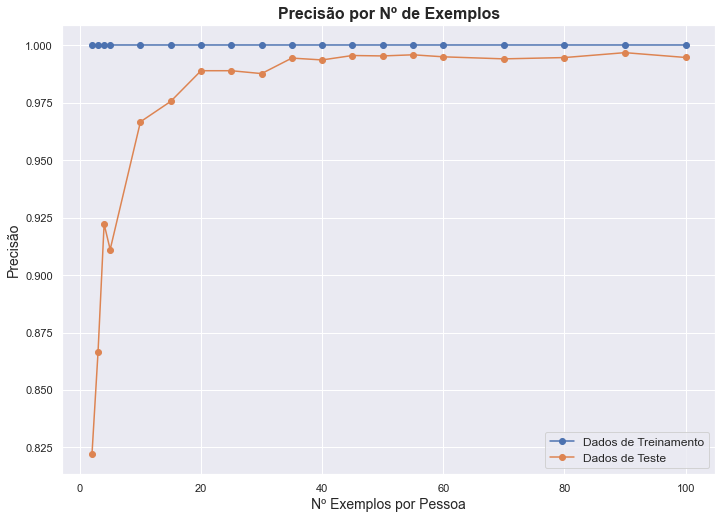

In [60]:
#cria gráfico com resultados de limitação de exemplos por pessoa
_, ax = plt.subplots(1,1)

ax.plot(example_range, list_accuracy_train, '-o', label= "Dados de Treinamento")
ax.plot(example_range, list_accuracy_test, '-o', label= "Dados de Teste")

ax.set_title("Precisão por Nº de Exemplos", fontsize=16, fontweight='bold')
ax.set_xlabel("Nº Exemplos por Pessoa", fontsize=14)
ax.set_ylabel('Precisão', fontsize=14)

ax.legend(loc="best", fontsize=12)

ax.grid('on')